In [47]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd

import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')
import PIL
from PIL import Image, ImageDraw, ImageFilter

%matplotlib inline

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Config

In [34]:
DATA_PATH='/media/bfortuner/bigguy/data/sealions/sample/'
RESULTS_PATH=DATA_PATH+'results/'
WEIGHTS_PATH=DATA_PATH+'models/'
IMAGE_PATH=DATA_PATH+'images/'
PROJECT_NAME='sealions'

In [115]:
# Notes
# cls -- sea lion class 
# tid -- train, train dotted, or test image id 
# _nb -- short for number
# x, y -- don't forget image arrays organized row, col, channels

cls_nb = 5
        
cls_names = (
    'adult_males',
    'subadult_males',
    'adult_females',
    'juveniles',
    'pups',
    'NOT_A_SEA_LION')

# Average actual color of dot centers.
cls_colors = (
    (243,8,5),          # red
    (244,8,242),        # magenta
    (87,46,10),         # brown 
    (25,56,176),        # blue
    (38,174,21),        # green
    )

train_nb = 947        
test_nb = 18636
        
paths = {
    # Source paths
    'sample'     : os.path.join(DATA_PATH, 'sample_submission.csv'),
    'counts'     : os.path.join(DATA_PATH, 'train', 'train.csv'),
    'train'      : os.path.join(DATA_PATH, 'train', '{tid}.jpg'),
    'dotted'     : os.path.join(DATA_PATH, 'traindotted', '{tid}.jpg'),
    'test'       : os.path.join(DATA_PATH, 'test', '{tid}.jpg'),
    # Data paths
    'coords'     : os.path.join(DATA_PATH, 'coords.csv'),  
}

dot_radius = 3

bad_train_ids = (
    3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 
    268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 
    507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 
    779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 
    913, 927, 946)

## Load and Prepare Data

In [88]:
def train_ids():
    """List of all valid train ids"""
    tids = range(0, train_nb)
    tids = list(set(tids) - set(bad_train_ids) )  # Remove bad ids
    tids.sort()
    return tids

def trainsmall_ids():
    return [i for i in range(41,51)]        # TrainSmall
    
def test_ids():
    return [i for i in range(0, test_nb)]

def path(name, **kwargs):
    """Return path to various source files"""
    path = paths[name].format(**kwargs)
    return path

def counts() :
    """A map from train_id to list of sea lion class counts"""
    counts = {}
    fn = path('counts')
    print (fn)
    with open(fn) as f:
        f.readline()
        for line in f:
            tid_counts = list(map(int, line.split(',')))
            counts[tid_counts[0]] = tid_counts[1:]
    return counts

In [67]:
counts = counts()

/media/bfortuner/bigguy/data/sealions/sample/train/train.csv


In [137]:
def _load_image(itype, tid, border=0):
    fn = path(itype, tid=tid)
    img = np.asarray(Image.open(fn))
    if border:
        height, width, channels = img.shape
        bimg = np.zeros( shape=(height+border*2, width+border*2, channels), dtype=np.uint8)
        bimg[border:-border, border:-border, :] = img
        img = bimg
    return img

def load_dotted_image(train_id, border=0):
    return _load_image('dotted', train_id, border)

def load_test_image(test_id, border=0):    
    return _load_image('test', test_id, border)

def load_train_image(train_id, border=0, mask=False):
    """Return image as numpy array

    border -- add a black border of this width around image
    mask -- If true mask out masked areas from corresponding dotted image
    """
    img = _load_image('train', train_id, border)
    if mask:
        # The masked areas are not uniformly black, presumable due to 
        # jpeg compression artifacts
        dot_img = _load_image('dotted', train_id, border).astype(np.uint16).sum(axis=-1)
        img = np.copy(img)
        img[dot_img<40] = 0
    return img

def get_paths_to_files(dir_path):
    filepaths = []
    fnames = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
        fnames.extend([f for f in filenames])
    return filepaths, fnames

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)[0]
    return filepaths[random.randrange(len(filepaths))]

def plot_img_array(img_arr, shape=(16,16)):
    # Plot numpy array image
    plt.figure(figsize=shape)
    plt.imshow(img_arr.astype('uint8'))
    plt.show()
    
def get_random_train_id(sample=True):
    if sample:
        trn_ids = trainsmall_ids()
    else:
        trn_ids = train_ids()
    rand_id = trn_ids[random.randrange(len(trn_ids))]
    return rand_id

def get_random_train_img_arr(sample=True):
    trn_id = get_random_train_id(sample)
    return load_train_image(trn_id)

In [127]:
plt.imshow??

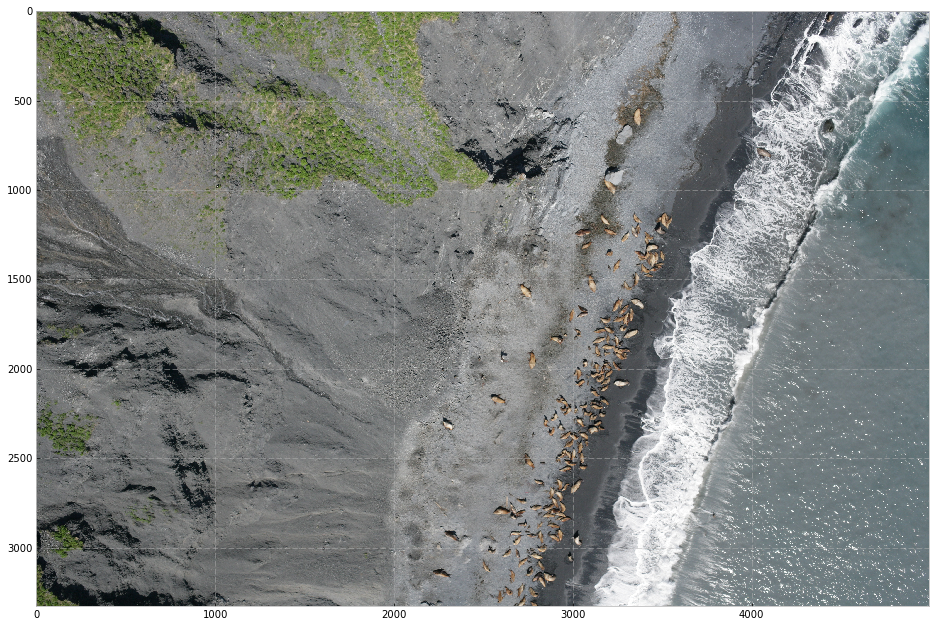

In [138]:
#Example Images
trn_img = load_train_image(41)
plot_img_array(trn_img)

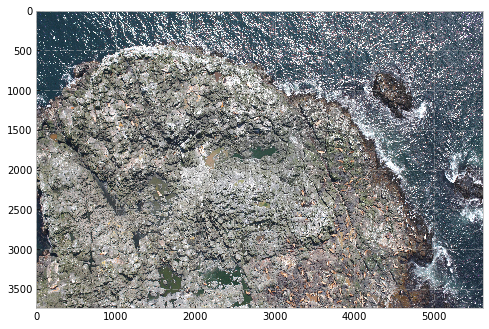

In [139]:
trn_id = get_random_train_id(True)
trn_arr = load_train_image(trn_id)
plot_img_array(trn_arr, shape=(8,8))

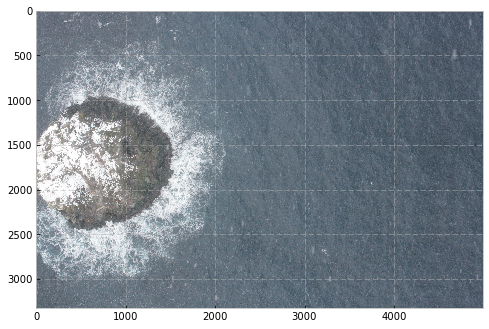

In [141]:
trn_arr = get_random_train_img_arr(True)
plot_img_array(trn_arr, shape=(8,8))

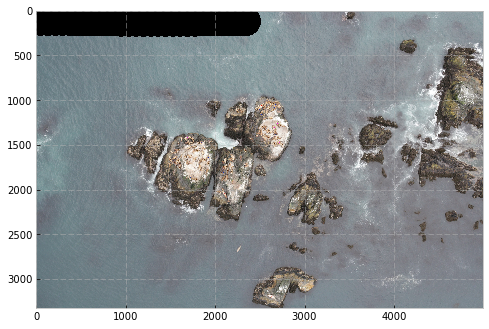

In [140]:
#Dotted Image
trn_id = get_random_train_id(True)
dot_arr = load_dotted_image(trn_id)
plot_img_array(dot_arr, shape=(8,8))

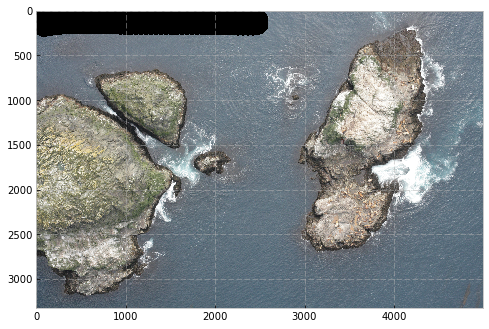

In [142]:
#Dotted Image
trn_id = get_random_train_id(True)
trn_w_mask_arr = load_train_image(trn_id, mask=True)
plot_img_array(trn_w_mask_arr, shape=(8,8))

## Metrics

In [45]:
def rmse(tid_counts, counts) :
    true_counts = counts

    error = np.zeros(shape=[5] )

    for tid in tid_counts:
        true_counts = counts[tid]
        obs_counts = tid_counts[tid]
        diff = np.asarray(true_counts) - np.asarray(obs_counts)
        error += diff*diff
    print(error)
    error /= len(tid_counts)
    rmse = np.sqrt(error).sum() / 5
    return rmse

## Model

## References

* https://www.kaggle.com/philschmidt/noaa-fisheries-steller-sea-lion-population-count/sea-lion-correlations-cv2-template-matching
* https://www.kaggle.com/radustoicescu/noaa-fisheries-steller-sea-lion-population-count/get-coordinates-using-blob-detection
* https://www.kaggle.com/asymptote/noaa-fisheries-steller-sea-lion-population-count/count-extract-sea-lions
* https://www.kaggle.com/radustoicescu/noaa-fisheries-steller-sea-lion-population-count/use-keras-to-classify-sea-lions-0-91-accuracy

**Satallite Unet Examples**
* https://www.kaggle.com/drn01z3/dstl-satellite-imagery-feature-detection/end-to-end-baseline-with-u-net-keras/code (similar view from above on small objects)
* https://www.kaggle.com/ceperaang/dstl-satellite-imagery-feature-detection/lb-0-42-ultimate-full-solution-run-on-your-hw/code
* https://www.kaggle.com/amanbh/dstl-satellite-imagery-feature-detection/visualize-polygons-and-image-data/code

**Spacenet challenge**
* https://github.com/SpaceNetChallenge/BuildingDetectors